In [1]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!wget https://download.pytorch.org/tutorial/data.zip

!unzip data.zip

--2021-07-24 17:16:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.37.116, 99.86.37.53, 99.86.37.74, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.37.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2021-07-24 17:16:33 (70.3 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['tu es plus grande que moi .', 'you re taller than i am .']


After all of these steps, our data is ready. Let's explore it a bit

In [3]:
sample = random.choice(pairs)
sample

['nous ne sommes pas ici pour t arreter .', 'we are not here to arrest you .']

In [4]:
type(pairs)

list

We want to create an embedding layer that has embedding value for each of the word we have in out input layer. So...



In [5]:
input_size = input_lang.n_words
hidden_size = 256

In [6]:
pairs[0:5]

[['j ai ans .', 'i m .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .'],
 ['je suis gras .', 'i m fat .'],
 ['je suis gros .', 'i m fat .']]

In order to work with embedding layer and the LSTM the inputs should be in the form of tensor, So we need to convert the sentences(words) to tensors.
First we'll split the sentences by whitespaces and convert each words into indices(using word2index[word])

In [7]:
input_sentence = sample[0]
target_sentence = sample[1]

input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in target_sentence.split(' ')]

input_indices, target_indices

([123, 297, 126, 246, 64, 1150, 217, 2561, 5],
 [77, 124, 147, 46, 532, 1423, 129, 4])

In [8]:
input_indices.append(EOS_token)
target_indices.append(EOS_token)

input_indices, target_indices

([123, 297, 126, 246, 64, 1150, 217, 2561, 5, 1],
 [77, 124, 147, 46, 532, 1423, 129, 4, 1])

In [9]:
input_tensor = torch.tensor(input_indices, dtype=torch.long, device= device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device= device)

In [10]:
embedding = nn.Embedding(input_size, hidden_size).to(device)
lstm = nn.LSTM(hidden_size, hidden_size).to(device)

In [11]:
embedded_input = embedding(input_tensor[0]) #first word only
embedded_input.shape

torch.Size([256])

We are working with 1 sample, but we would be working for a batch. Let's fix that by converting our input_tensor into a fake batch


In [12]:
input_tensor.shape, input_tensor.view(-1, 1).shape

(torch.Size([10]), torch.Size([10, 1]))

In [13]:
print(embedded_input.shape)
embedded_input = embedding(input_tensor[0].view(-1, 1))
print(embedded_input.shape)

torch.Size([256])
torch.Size([1, 1, 256])


Let's build our LSTM, initialize the hidden state and cell state with Zeros(Empty state)

In [14]:
(hidden,ct) = torch.zeros(1, 1, 256, device=device),torch.zeros(1, 1, 256, device=device)

In [15]:
embedded_input = embedding(input_tensor[0].view(-1, 1))
output, (hidden,ct) = lstm(embedded_input, (hidden,ct))

In [16]:
embedded_input.shape,hidden.shape,ct.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [17]:
output.shape, output[0, 0].shape

(torch.Size([1, 1, 256]), torch.Size([256]))

In [18]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
encoder_outputs.shape

torch.Size([10, 256])

In [19]:
input_tensor.size(), input_tensor.size()[0]

(torch.Size([10]), 10)

In [20]:
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)

(encoder_hidden,encoder_ct) = torch.zeros(1, 1, 256, device=device),torch.zeros(1, 1, 256, device=device)

for i in range(input_tensor.size()[0]):  
  embedded_input = embedding(input_tensor[i].view(-1, 1))
  output, (encoder_hidden,encoder_ct) = lstm(embedded_input, (encoder_hidden,encoder_ct))
  encoder_outputs[i] += output[0,0]

In [21]:
encoder_outputs.shape, encoder_hidden.shape

(torch.Size([10, 256]), torch.Size([1, 1, 256]))

In [22]:
encoder_outputs[0:4]

tensor([[-0.1486, -0.1968,  0.0773,  ...,  0.1279,  0.1234,  0.0259],
        [ 0.0926, -0.0708,  0.2705,  ...,  0.0430,  0.1028,  0.0806],
        [ 0.2511, -0.1242,  0.2035,  ..., -0.0465,  0.1905,  0.0920],
        [-0.0133, -0.1355,  0.1795,  ..., -0.0090,  0.0777, -0.0481]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [23]:
encoder_outputs[7:10]

tensor([[-1.1505e-02, -2.6913e-01, -2.0070e-01, -1.1235e-01,  9.0245e-02,
         -6.9865e-02, -1.8906e-01,  3.6212e-02,  2.3004e-02,  1.9877e-01,
         -3.6911e-02,  6.2505e-02, -2.7181e-01,  2.7419e-02,  7.0394e-02,
         -1.1471e-01,  1.3626e-01, -1.5491e-01,  1.0497e-01, -7.5368e-02,
         -1.8615e-01,  2.9882e-02,  9.8233e-02,  1.5778e-01, -3.9313e-02,
          1.8931e-01, -9.9682e-02,  5.0586e-04,  1.7432e-01, -1.8087e-02,
         -1.1080e-01,  2.3366e-01,  1.1903e-01,  1.3074e-01, -1.9262e-01,
          2.3204e-01,  2.2612e-01, -1.4893e-02, -1.2812e-01,  2.4353e-01,
          2.0687e-01, -6.0848e-02,  9.0285e-02, -4.4677e-02,  1.3843e-02,
         -1.0409e-01, -1.8012e-02, -1.6731e-02, -8.4804e-02,  1.0364e-02,
         -2.7768e-02, -1.4895e-01,  5.4890e-02,  7.6249e-02,  1.5958e-01,
          4.3336e-02, -1.3671e-01, -1.4050e-01, -1.1731e-01,  1.5275e-01,
         -1.3382e-03,  6.3686e-03,  2.4006e-03,  1.0428e-01,  4.1602e-02,
         -5.7921e-02,  6.0362e-02, -3.

Input Sentence: nous ne sommes pas ici pour t arreter .
Target Sentence: we are not here to arrest you .
Input indices: [123, 297, 126, 246, 64, 1150, 217, 2561, 5]
Target indices: [123, 297, 126, 246, 64, 1150, 217, 2561, 5]
After adding the <EOS> token
Input indices: [123, 297, 126, 246, 64, 1150, 217, 2561, 5, 1]
Target indices: [123, 297, 126, 246, 64, 1150, 217, 2561, 5, 1]
Input tensor: tensor([ 123,  297,  126,  246,   64, 1150,  217, 2561,    5,    1],
       device='cuda:0')
Target tensor: tensor([  77,  124,  147,   46,  532, 1423,  129,    4,    1], device='cuda:0')



Encoder part

Step 0
Word => nous

Input Tensor => tensor(123, device='cuda:0')



Step 1
Word => ne

Input Tensor => tensor(297, device='cuda:0')



Step 2
Word => sommes

Input Tensor => tensor(126, device='cuda:0')



Step 3
Word => pas

Input Tensor => tensor(246, device='cuda:0')



Step 4
Word => ici

Input Tensor => tensor(64, device='cuda:0')



Step 5
Word => pour

Input Tensor => tensor(1150, device=

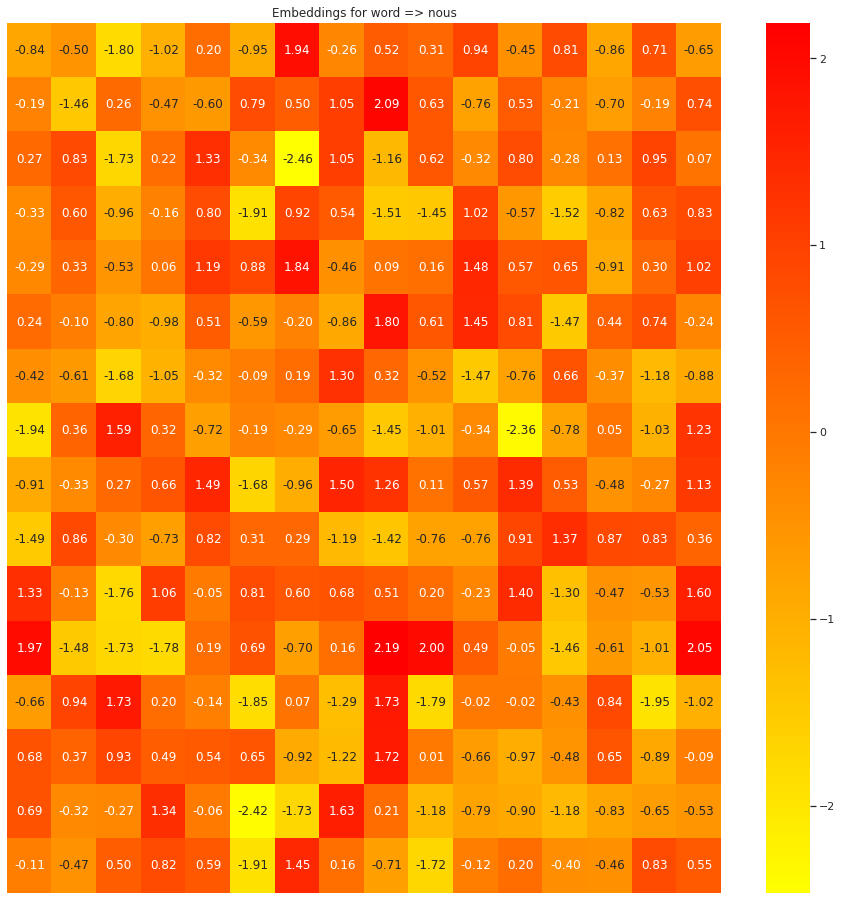

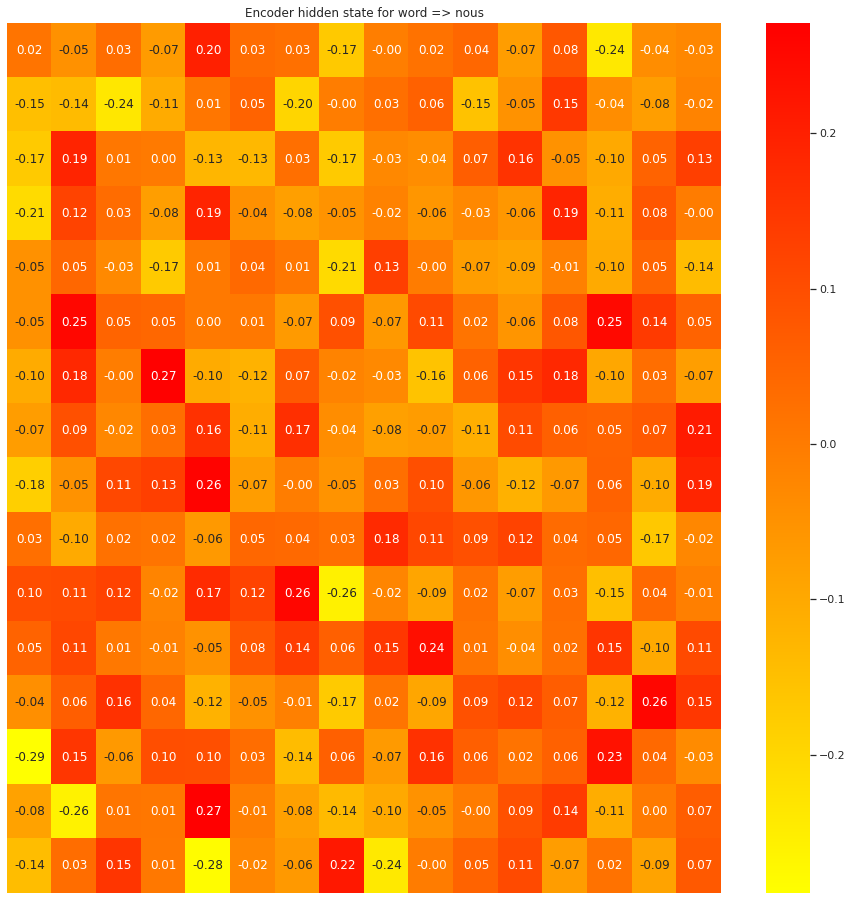

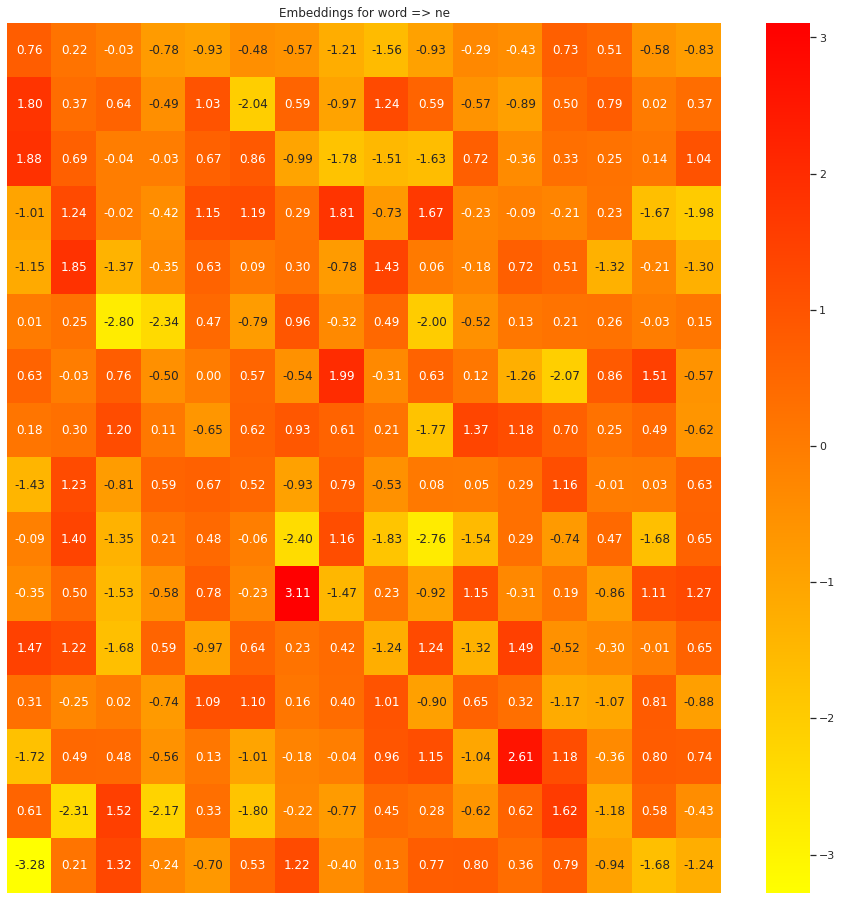

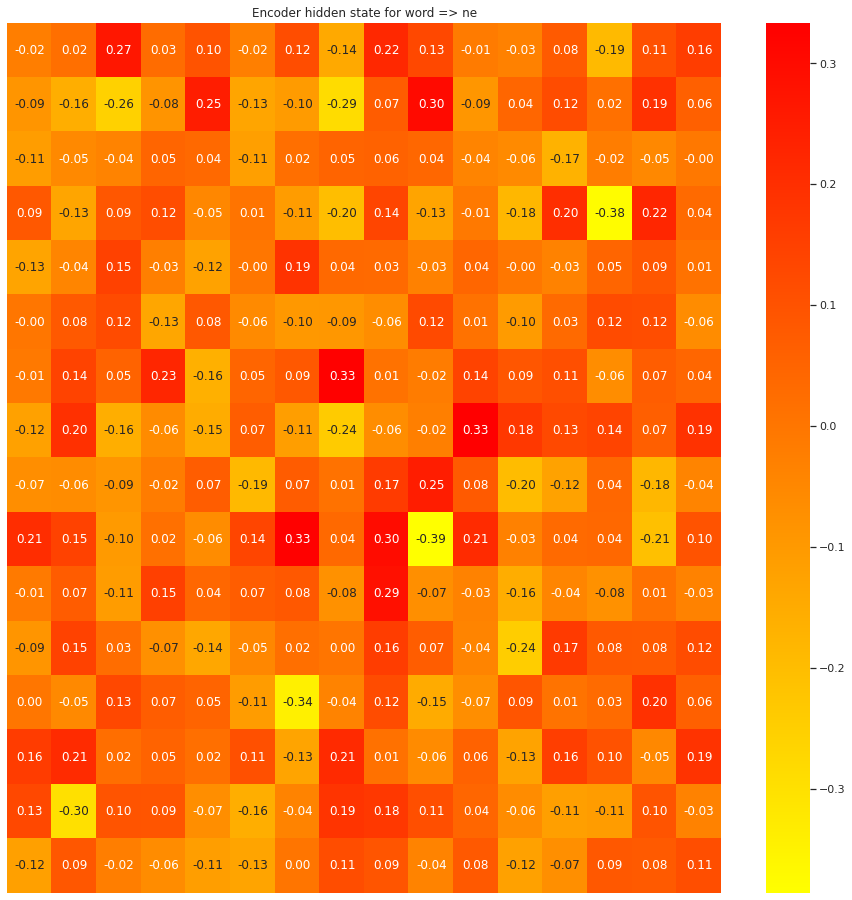

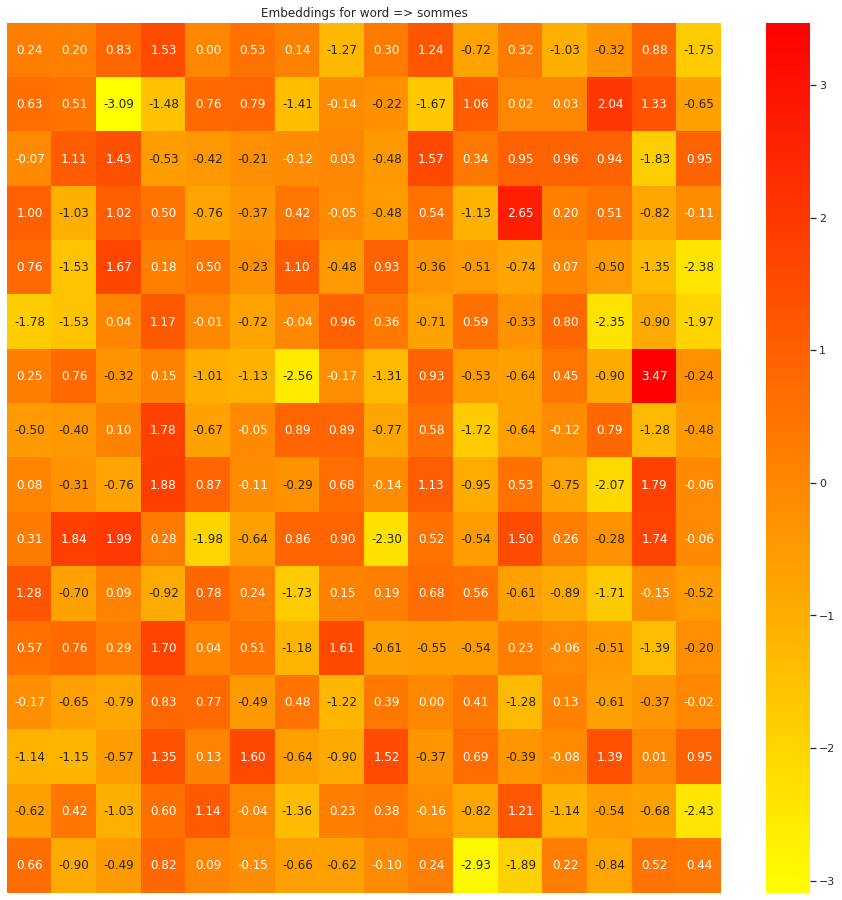

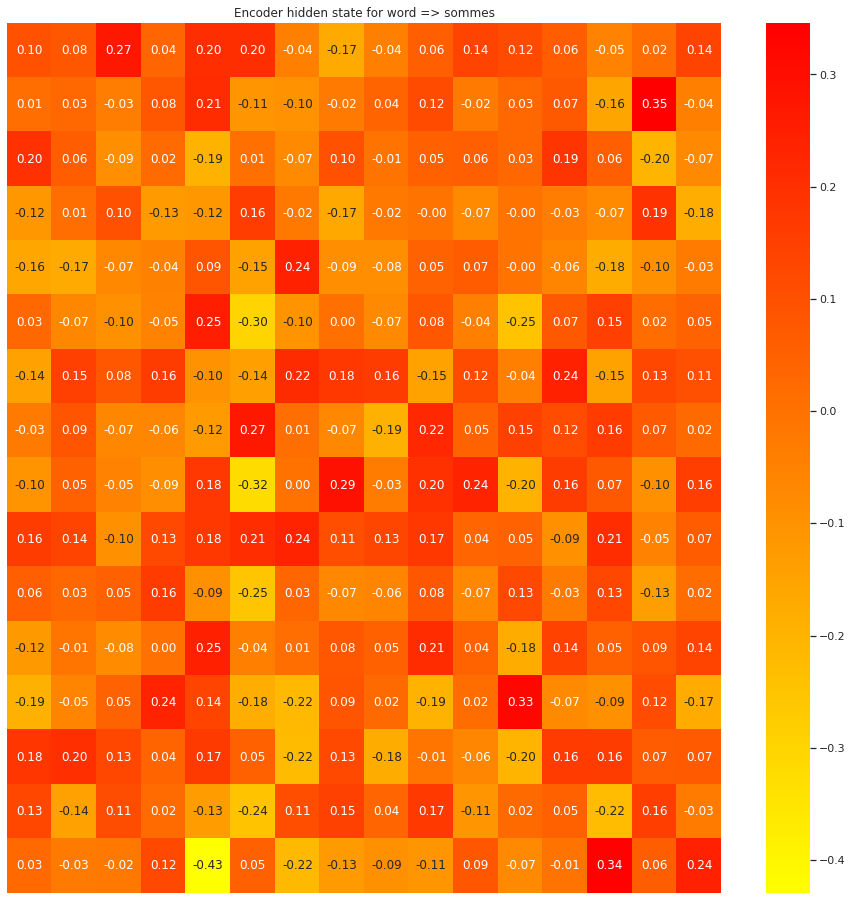

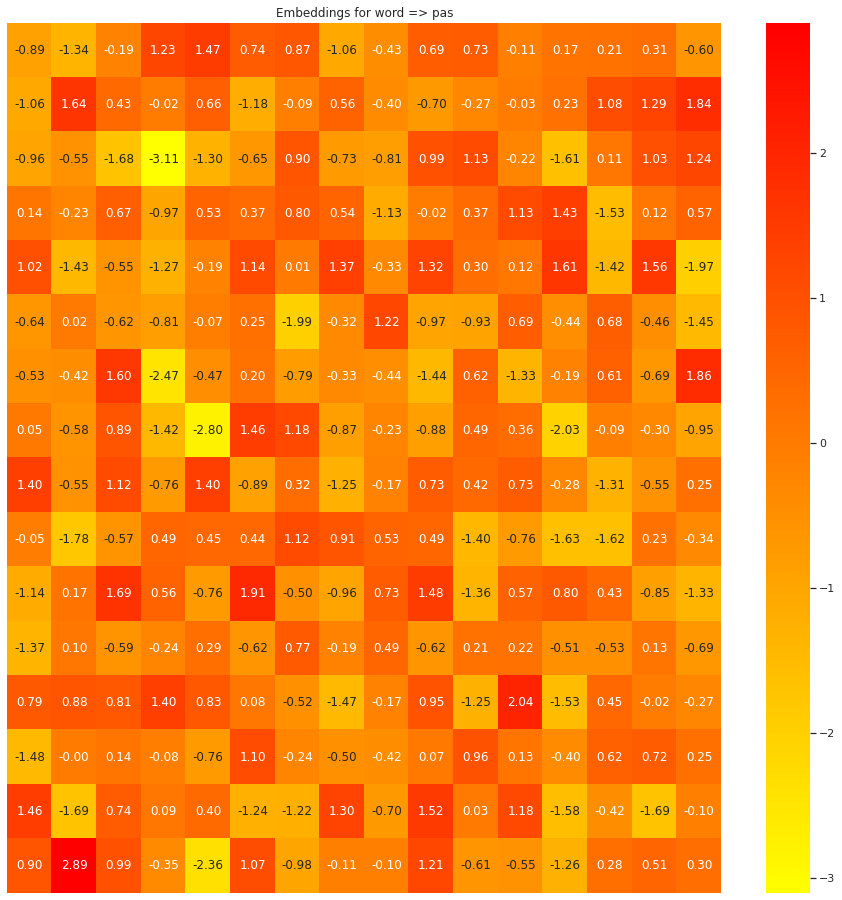

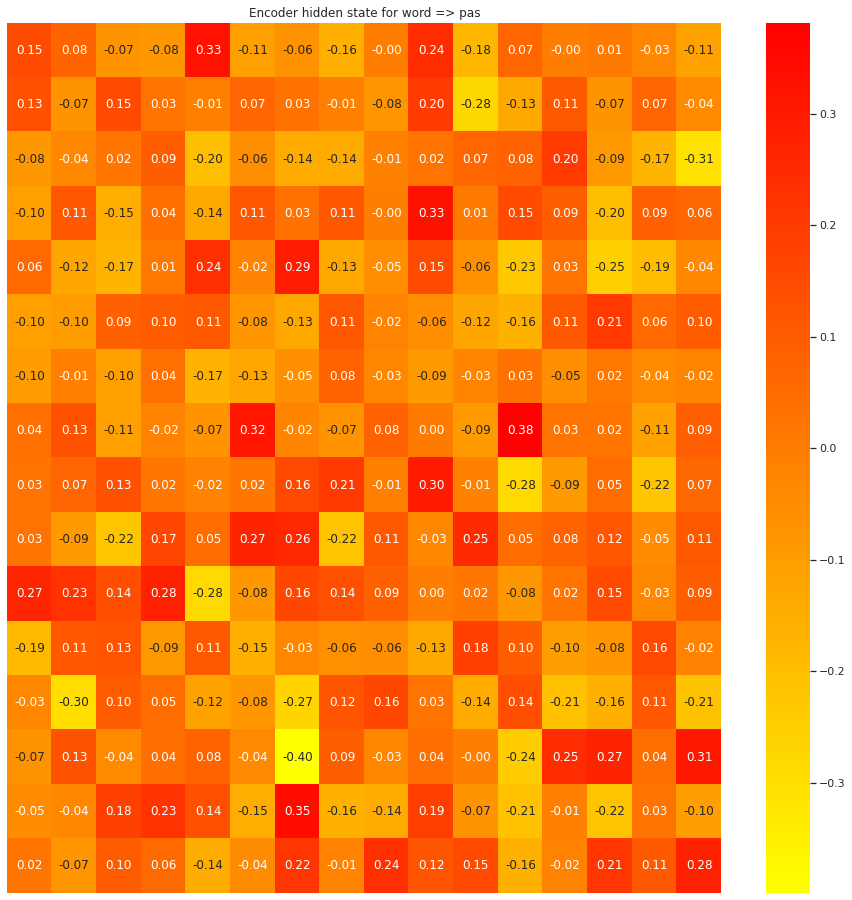

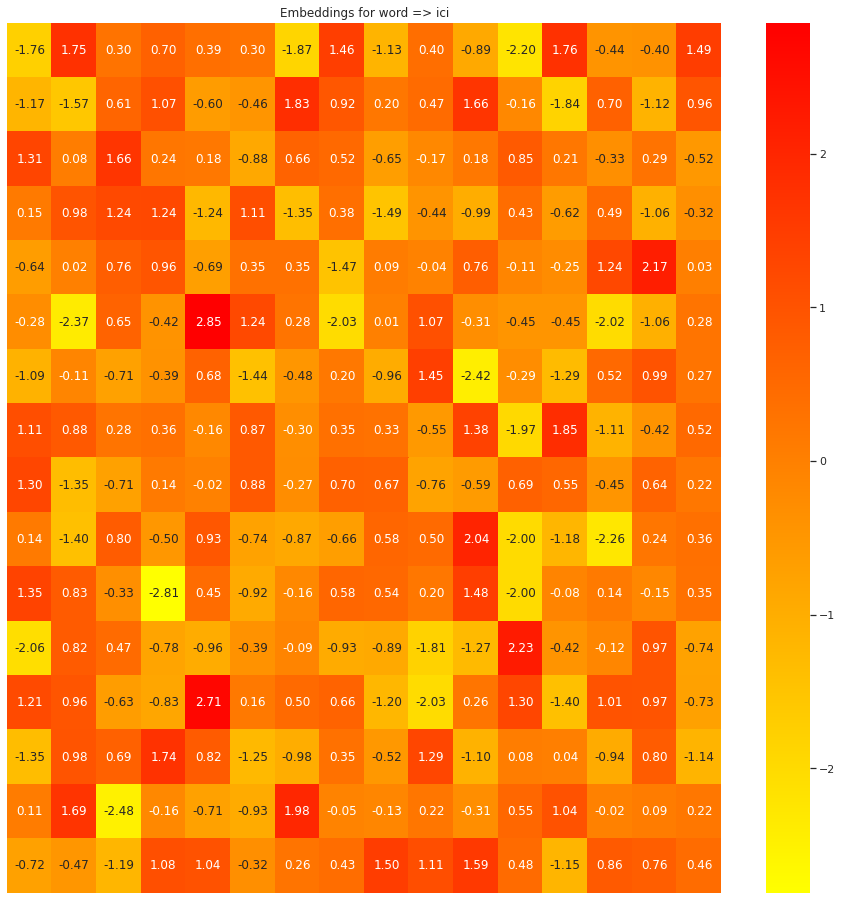

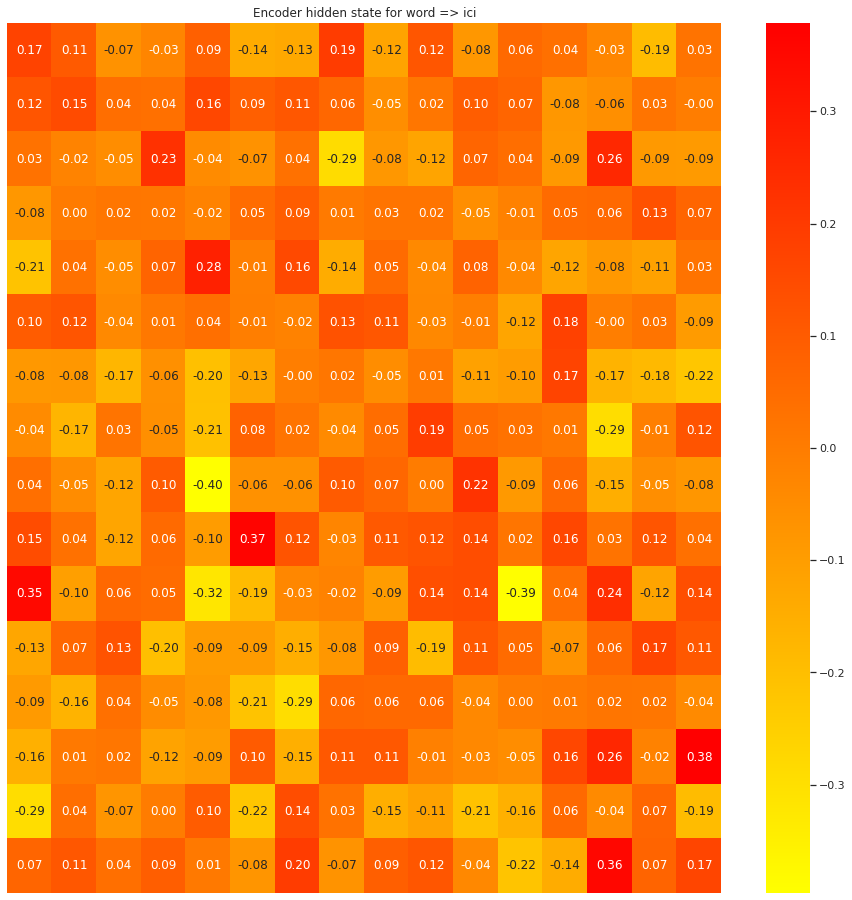

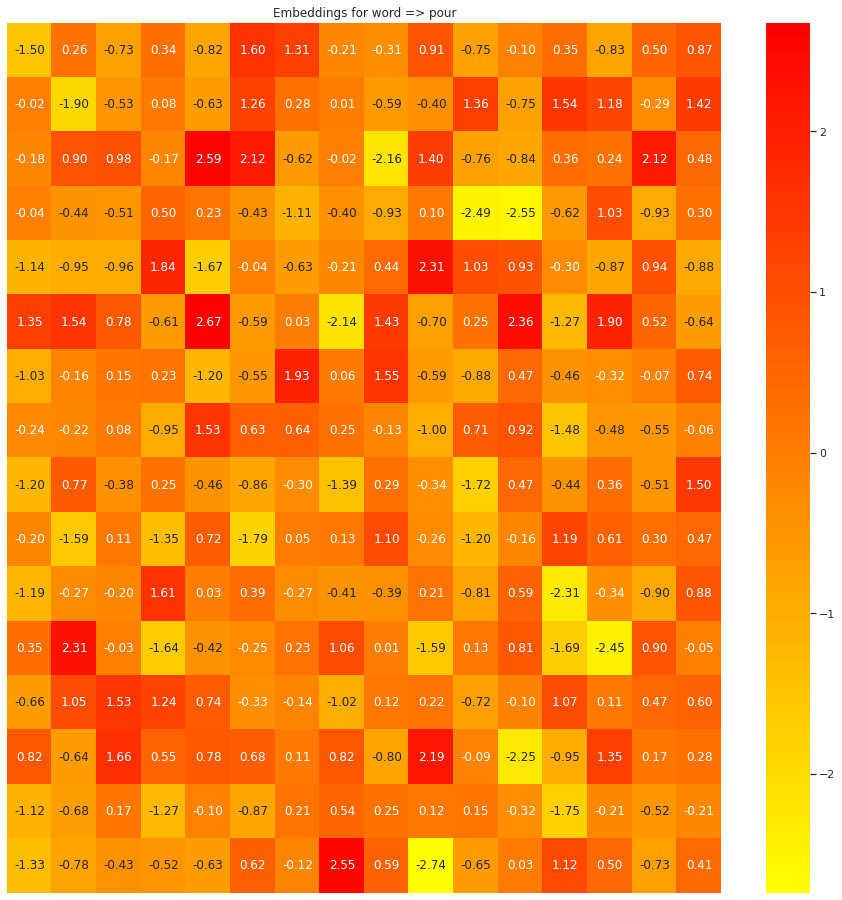

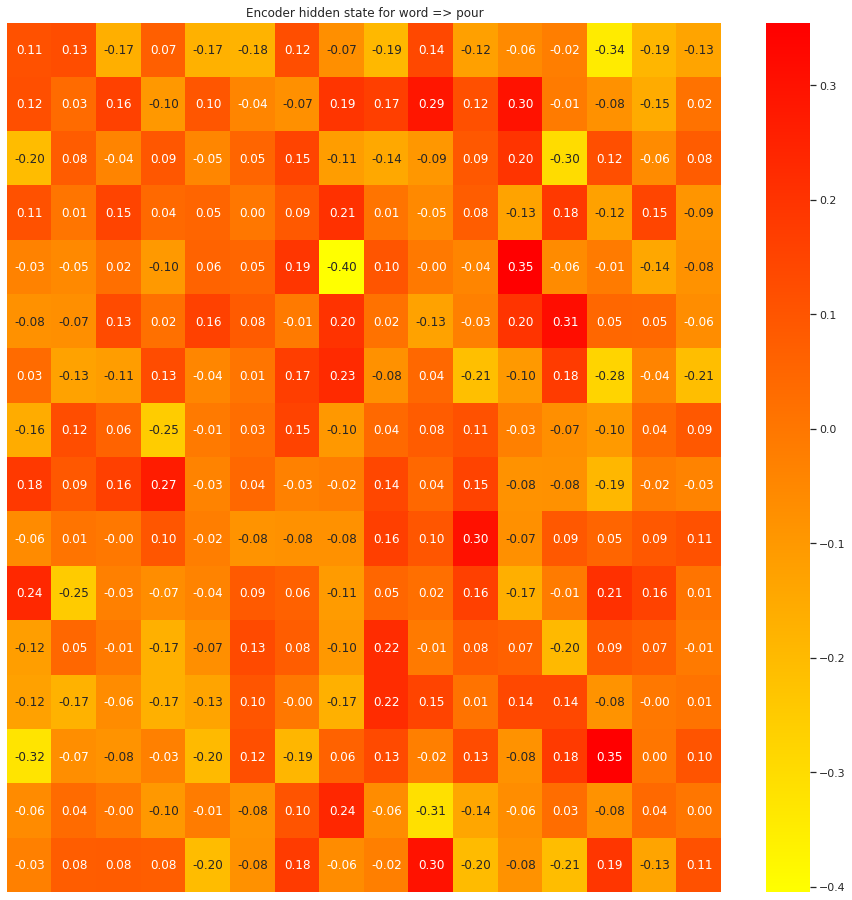

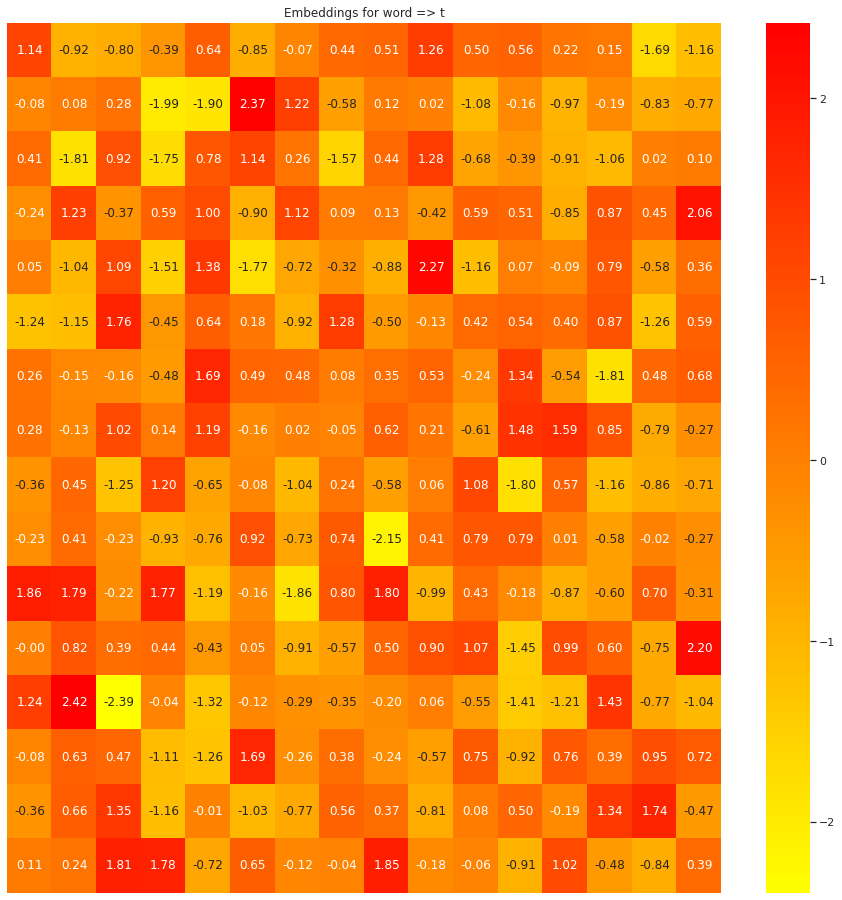

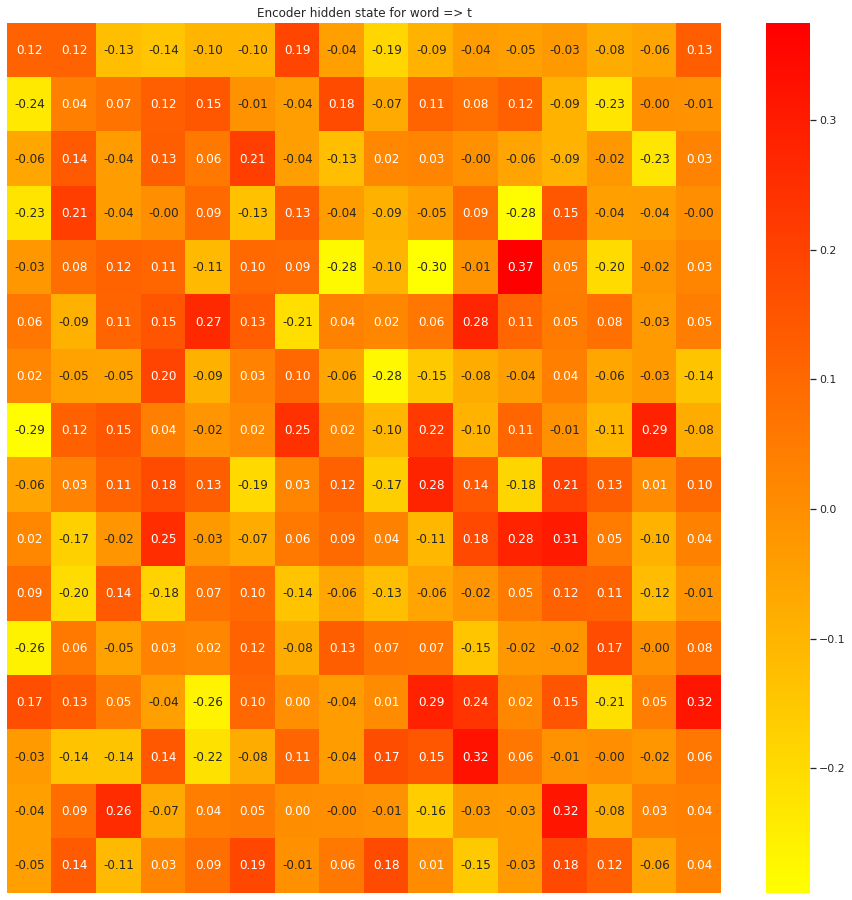

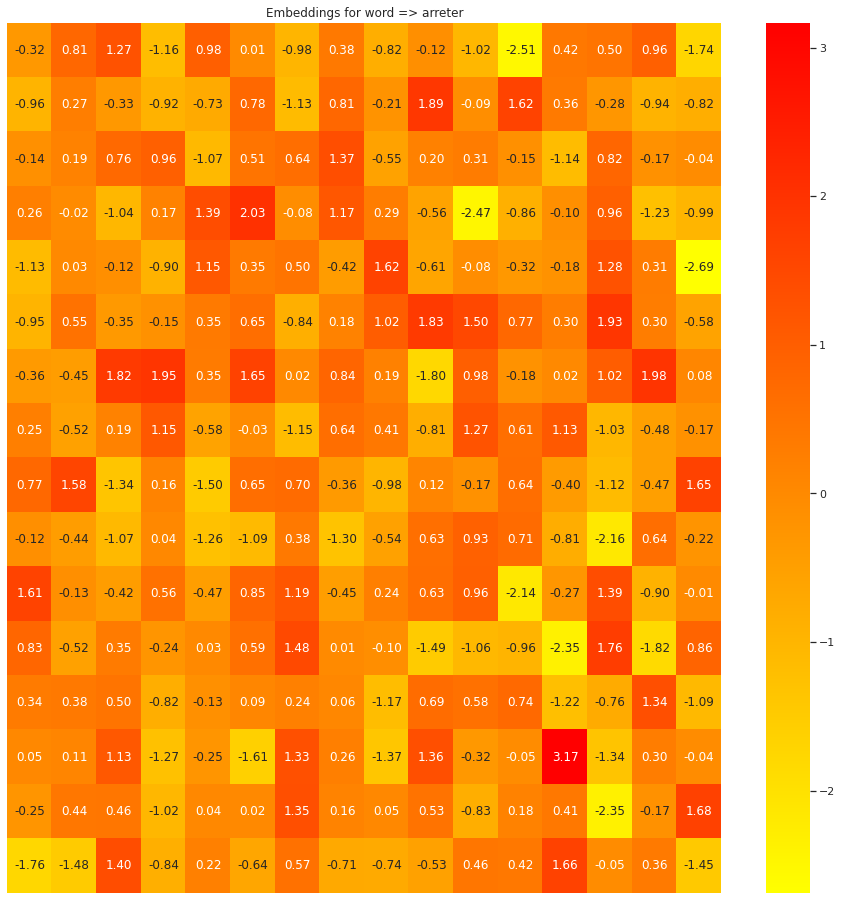

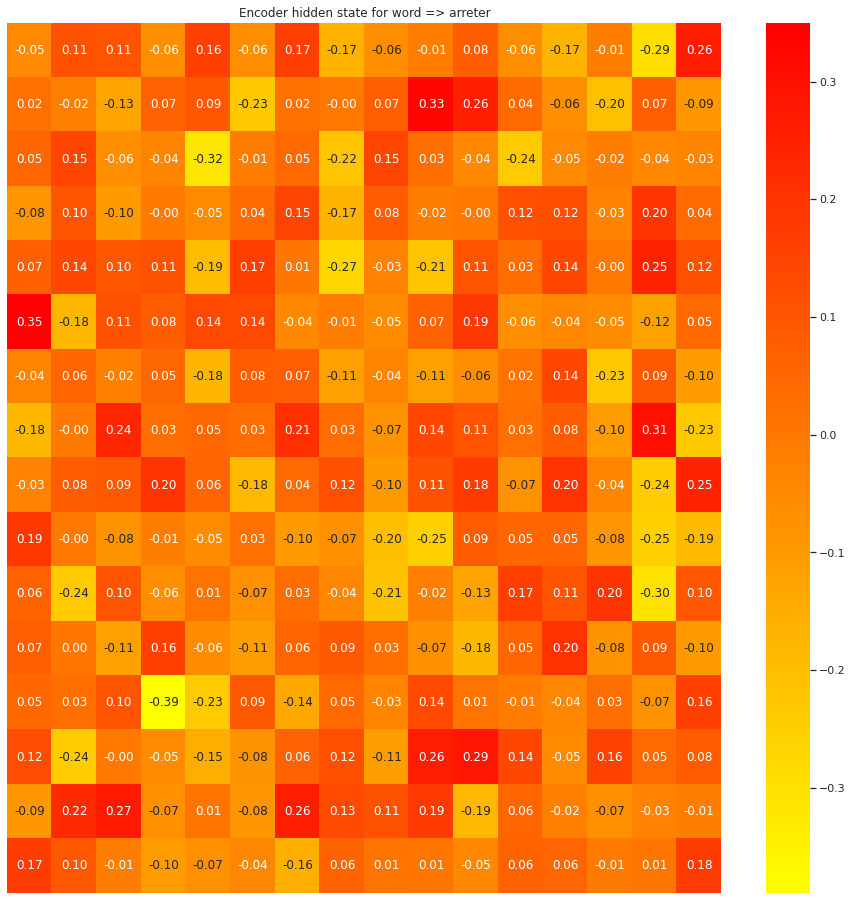

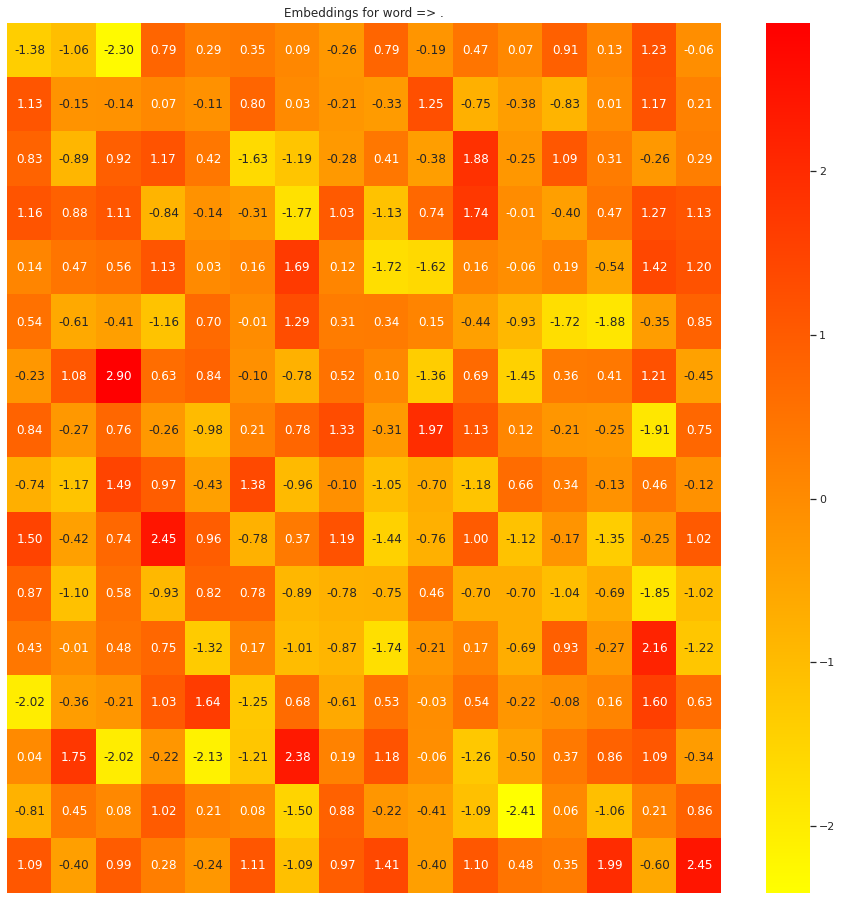

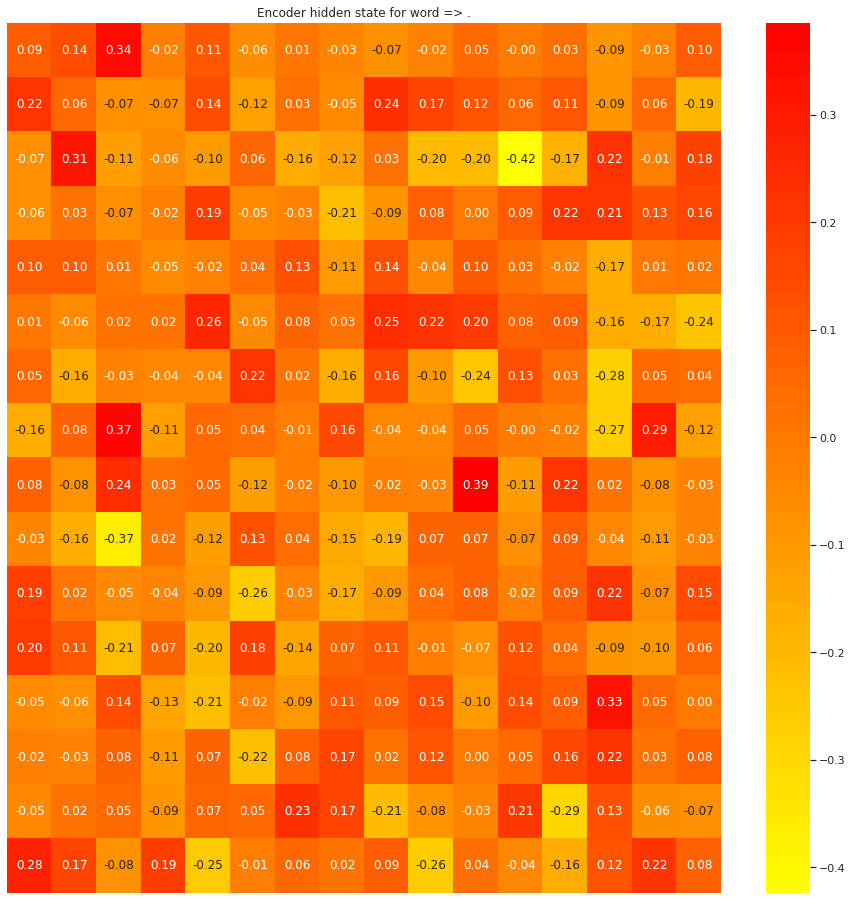

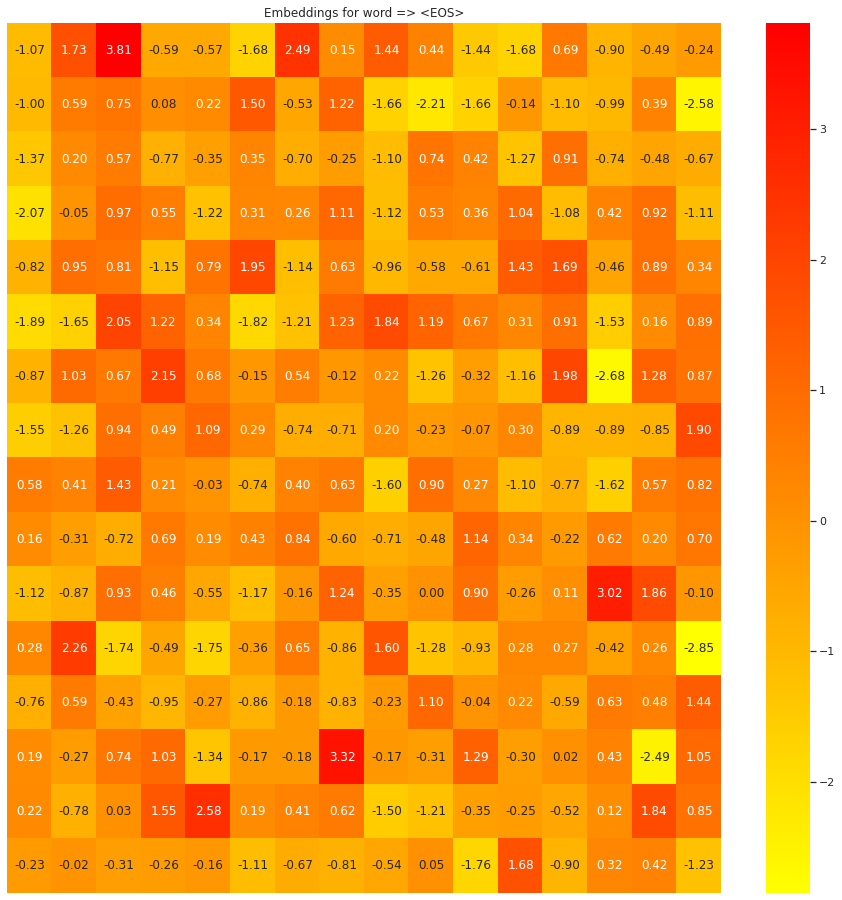

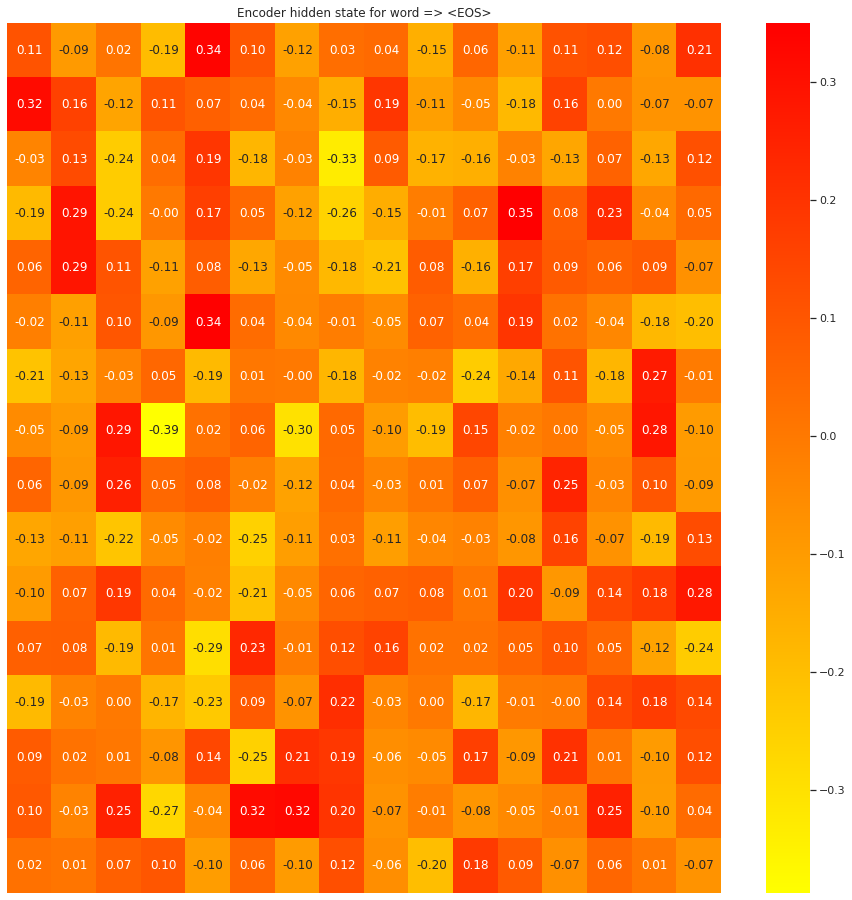

In [62]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

input_sentence = sample[0]
target_sentence = sample[1]
print("Input Sentence:",sample[0])
print("Target Sentence:",sample[1])

input_indices = [input_lang.word2index[word] for word in input_sentence.split(' ')]
target_indices = [output_lang.word2index[word] for word in target_sentence.split(' ')]
print("Input indices:",input_indices)
print("Target indices:",input_indices)

input_indices.append(EOS_token)
target_indices.append(EOS_token)
print("After adding the <EOS> token")
print("Input indices:",input_indices)
print("Target indices:",input_indices)

input_tensor = torch.tensor(input_indices, dtype=torch.long, device= device)
output_tensor = torch.tensor(target_indices, dtype=torch.long, device= device)
print("Input tensor:",input_tensor)
print("Target tensor:",output_tensor)
print("\n\n")

print("Encoder part\n")
encoder_outputs = torch.zeros(MAX_LENGTH, 256, device=device)
(encoder_hidden,encoder_ct) = torch.zeros(1, 1, 256, device=device),torch.zeros(1, 1, 256, device=device)

for i in range(input_tensor.size()[0]):
  
  if (i<input_tensor.size()[0]-1):
    input_word = input_sentence.split(' ')[i] 
  else:
    input_word = "<EOS>"
  print('Step %d\nWord => %s\n'%(i,input_word))
  print("Input Tensor =>",input_tensor[i]) 
  embedded_input = embedding(input_tensor[i].view(-1, 1))
  embedded_input_cpu = embedded_input.cpu()
  plt.figure(figsize = (16,16))
  seaborn.heatmap(embedded_input_cpu.detach().numpy().reshape(-1, 16), fmt=".2f",annot=True, cmap="autumn_r").set(title=f"Embeddings for word => {input_word}")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  output, (encoder_hidden,encoder_ct) = lstm(embedded_input, (encoder_hidden,encoder_ct))
  output_cpu = output[0,0].cpu()
  plt.figure(figsize = (16,16))
  seaborn.heatmap(output_cpu.detach().numpy().reshape(-1, 16), fmt=".2f",annot=True, cmap="autumn_r").set(title=f"Encoder hidden state for word => {input_word}")
  plt.xticks([])
  plt.yticks([])
  plt.show()
  encoder_outputs[i] += output[0,0]
  print("\n\n")



Finally our Encoder is fully ready. Now let's look at the class we wrote in the last class to see what we missed!

```
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
```

Cool! Next let's build out Decoder where we have attention in-built.

# Decoder with Attention

Here is the plan. 

1. First input to the decoder will be SOS_token, later inputs would be the words it predicted (unless we implement teacher forcing)
2. decoder/GRU's hidden state will be initialized with the encoder's last hidden state
3. we will use gru's hidden state and last prediction to generate attention weight using a FC layer. 
4. this attention weight will be used to weigh the encoder_outputs using batch matric multiplication. This will give us a NEW view on how to look at encoder_states.
5. this attention applied encoder_states will then be concatenated with the input, and then sent a linear layer and _then_ sent to the GRU. 
6. GRU's output will be sent to a FC layer to predict one of the output_language words

Let's prepare all the inputs we need to do this


In [25]:
# first input
decoder_input = torch.tensor([[SOS_token]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
decoded_words = []

In [26]:
output_size = output_lang.n_words

embedding = nn.Embedding(output_size, 256).to(device)

In [27]:
embedded = embedding(decoder_input)
embedded.shape

torch.Size([1, 1, 256])

In [28]:
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)

In [29]:
embedded.shape, decoder_hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [30]:
torch.cat((embedded, decoder_hidden), 1).shape

torch.Size([1, 2, 256])

We don't want that. We wanted to concatenate them. 

In [31]:
torch.cat((embedded[0], decoder_hidden[0]), 1).shape

torch.Size([1, 512])

In [32]:
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights

tensor([[ 0.8782, -0.2768,  0.4192, -0.3488, -0.5618, -0.0565, -0.1604, -0.0801,
         -0.5544, -0.0369]], device='cuda:0', grad_fn=<AddmmBackward>)

In [33]:
import torch.nn.functional as F

attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_weights

tensor([[0.0913, 0.0629, 0.1328, 0.0682, 0.1912, 0.1258, 0.0597, 0.0613, 0.0976,
         0.1092]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Now let's **apply** this attention to the encoder_inputs

In [34]:
attn_weights.shape, encoder_outputs.shape

(torch.Size([1, 10]), torch.Size([10, 256]))

In [35]:
attn_weights.unsqueeze(0).shape, encoder_outputs.unsqueeze(0).shape

(torch.Size([1, 1, 10]), torch.Size([1, 10, 256]))

In [36]:
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
attn_applied.shape

torch.Size([1, 1, 256])

In [37]:
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)

embedded.shape, attn_applied.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [38]:
torch.cat((embedded, attn_applied), 1).shape, torch.cat((embedded[0], attn_applied[0]), 1).shape

(torch.Size([1, 2, 256]), torch.Size([1, 512]))

In [39]:
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm.shape

torch.Size([1, 256])

In [40]:
lstm = nn.LSTM(256, 256).to(device)

In [41]:
decoder_hidden.shape, input_to_lstm.shape

(torch.Size([1, 1, 256]), torch.Size([1, 256]))

In [42]:
input_to_lstm.unsqueeze(0).shape

torch.Size([1, 1, 256])

In [43]:
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm.unsqueeze(0), (decoder_hidden,decoder_ct))
output.shape, decoder_hidden.shape

(torch.Size([1, 1, 256]), torch.Size([1, 1, 256]))

In [44]:
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)

In [45]:
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
output, output.shape

(tensor([[0.0003, 0.0004, 0.0003,  ..., 0.0003, 0.0003, 0.0004]],
        device='cuda:0', grad_fn=<SoftmaxBackward>), torch.Size([1, 2803]))

In [46]:
output.data.topk(1)

torch.return_types.topk(values=tensor([[0.0004]], device='cuda:0'), indices=tensor([[235]], device='cuda:0'))

In [47]:
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()]

'bigot'

😅
Let's combine all of these steps, we we have just processed 1 input till now. 

In [48]:
top_index.item()

235

In [49]:
decoder_input = torch.tensor([[SOS_token]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedding = nn.Embedding(output_size, 256).to(device)
embedded = embedding(decoder_input)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
lstm = nn.LSTM(256, 256).to(device)
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()]

'!'

In [50]:
embedding = nn.Embedding(output_size, 256).to(device)
attn_weight_layer = nn.Linear(256 * 2, 10).to(device)
input_to_lstm_layer = nn.Linear(256 * 2, 256).to(device)
lstm = nn.LSTM(256, 256).to(device)
output_word_layer = nn.Linear(256, output_lang.n_words).to(device)


decoder_input = torch.tensor([[SOS_token]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights


('shock',
 tensor([[0.1575, 0.0407, 0.0815, 0.1612, 0.1488, 0.0743, 0.0956, 0.0846, 0.0885,
          0.0673]], device='cuda:0', grad_fn=<SoftmaxBackward>))

In [51]:
decoder_input = torch.tensor([[top_index.item()]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('toothache',
 tensor([[0.0661, 0.1127, 0.1098, 0.1181, 0.0712, 0.0977, 0.1407, 0.0859, 0.0770,
          0.1208]], device='cuda:0', grad_fn=<SoftmaxBackward>))

In [52]:
decoder_input = torch.tensor([[target_indices[2]]], device=device)
(decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
output_size = output_lang.n_words
embedded = embedding(decoder_input)
attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
attn_weights = F.softmax(attn_weights, dim = 1)
attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
input_to_lstm = input_to_lstm.unsqueeze(0)
output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
output = F.relu(output)
output = F.softmax(output_word_layer(output[0]), dim = 1)
top_value, top_index = output.data.topk(1)
output_lang.index2word[top_index.item()], attn_weights

('loving',
 tensor([[0.1849, 0.0657, 0.1640, 0.0489, 0.1327, 0.0932, 0.0978, 0.0573, 0.0646,
          0.0909]], device='cuda:0', grad_fn=<SoftmaxBackward>))

Attention Decoder part With full Teacher forcing


Step 0
Expected output(word) => we 
Expected output(Index) => 77 
Predicted output(word) => deceiving 
Predicted output(Index) => 2078 

Step 1
Expected output(word) => are 
Expected output(Index) => 124 
Predicted output(word) => find 
Predicted output(Index) => 1399 

Step 2
Expected output(word) => not 
Expected output(Index) => 147 
Predicted output(word) => equal 
Predicted output(Index) => 1557 

Step 3
Expected output(word) => here 
Expected output(Index) => 46 
Predicted output(word) => ignoring 
Predicted output(Index) => 1251 

Step 4
Expected output(word) => to 
Expected output(Index) => 532 
Predicted output(word) => australians 
Predicted output(Index) => 1091 

Step 5
Expected output(word) => arrest 
Expected output(Index) => 1423 
Predicted output(word) => weight 
Predicted output(Index) => 907 


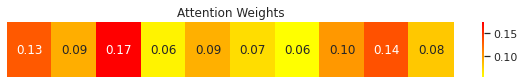

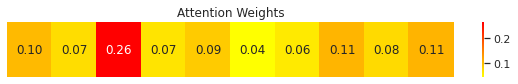

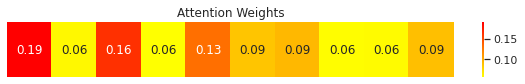

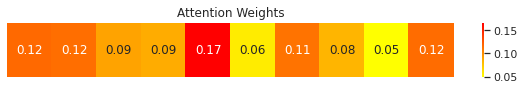

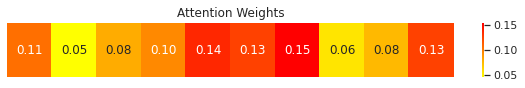

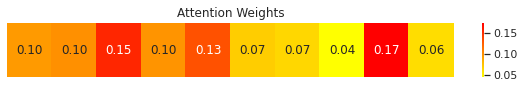

In [63]:
print("Attention Decoder part With full Teacher forcing\n")
for i in range(6):
  print('\nStep %d'%(i))
  print('Expected output(word) => %s '% target_sentence.split(" ")[i])
  print('Expected output(Index) => %d '% target_indices[i])
  decoder_input = torch.tensor([[target_indices[i]]], device=device)
  (decoder_hidden,decoder_ct) = (encoder_hidden,encoder_ct)
  output_size = output_lang.n_words
  embedded = embedding(decoder_input)
  attn_weights = attn_weight_layer(torch.cat((embedded[0], decoder_hidden[0]), 1))
  attn_weights = F.softmax(attn_weights, dim = 1)
  attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
  attn_weights_cpu = attn_weights.cpu()
  input_to_lstm = input_to_lstm_layer(torch.cat((embedded[0], attn_applied[0]), 1))
  input_to_lstm = input_to_lstm.unsqueeze(0)
  output, (decoder_hidden,decoder_ct) = lstm(input_to_lstm, (decoder_hidden,decoder_ct))
  output = F.relu(output)  
  output = F.softmax(output_word_layer(output[0]), dim = 1)
  top_value, top_index = output.data.topk(1)
  print('Predicted output(word) => %s '% output_lang.index2word[top_index.item()])
  print('Predicted output(Index) => %d '% top_index.item())  
  plt.figure(figsize = (10,1))
  seaborn.heatmap(attn_weights_cpu.detach().numpy().reshape(-1, 10), fmt=".2f",annot=True, cmap="autumn_r").set(title=f"Attention Weights")
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [54]:
target_indices, target_sentence, input_sentence

([77, 124, 147, 46, 532, 1423, 129, 4, 1],
 'we are not here to arrest you .',
 'nous ne sommes pas ici pour t arreter .')

In [55]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [56]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()